In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
LABELS = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 150
IMG_SIZE_TUPLE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32

# Adjust Paths when using with a different Data Source or google Account
TRAIN_PATH = "/content/drive/MyDrive/Machine_learning/datasets/pneumonia/train"
TEST_PATH = "/content/drive/MyDrive/Machine_learning/datasets/pneumonia/test"
MODEL_SAVE_FOLDER = "/content/drive/MyDrive/Machine_learning/datasets/pneumonia/models"

# Used to split train data into train and test data
TRAIN_VAL_SPLIT = 0.8
random.seed(10)


In [ ]:
def get_data(directory_path: str =TRAIN_PATH):
  images =  []
  labels = []
  # called for 'NORMAL' and 'PNEUMONIA'
  for label in LABELS:
    # get folder name for label
    img_folder_path = os.path.join(directory_path, label)
    # Iterate over all images in the label folder
    for img_path_relative in os.listdir(img_folder_path):
      img_path_absolute = os.path.join(img_folder_path, img_path_relative)
      img = cv2.imread(img_path_absolute)
      # Resize Images
      img = cv2.resize(img, IMG_SIZE_TUPLE)
      images.append(img)
      labels.append(LABELS.index(label))
    
  return np.array(images), np.array(labels)

In [ ]:
# Get Data in form of np Arrays

train_val_data, train_val_labels = get_data()
test_data, test_labels = get_data(TEST_PATH)

In [ ]:
# Shuffle train/val data and labels in unison
permutation = np.random.permutation(len(train_val_data))


train_val_data = train_val_data[permutation]
train_val_labels = train_val_labels[permutation]

In [ ]:
# Split Data into train/val data/labels using set Ratio

from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, train_size=TRAIN_VAL_SPLIT, random_state=10)

del train_val_data
del train_val_labels

In [ ]:
# check shape of data
print(train_data.shape)
print(val_data.shape)
print(train_labels.shape)
print(val_labels.shape)

(4172, 150, 150, 3)
(1044, 150, 150, 3)
(4172,)
(1044,)


In [ ]:
# Compute Class Weights to check for imbalance
from sklearn.utils import class_weight

class_weights_train = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
normalized_class_weights_train = class_weights_train * 1 / min(class_weights_train)
print(class_weights_train)
print(normalized_class_weights_train)


class_weights_val = class_weight.compute_class_weight('balanced', classes=np.unique(val_labels), y=val_labels)
class_weights_test = class_weight.compute_class_weight('balanced', classes=np.unique(test_labels), y=test_labels)

print(class_weights_val)
print(class_weights_test)

[1.93686165 0.67399031]
[2.87372331 1.        ]
[1.97727273 0.66923077]
[1.33333333 0.8       ]


In [ ]:
# Normalize Data because CNN works better with Data from 0 to 1 rather than 0 to 255
train_data = train_data / 255
val_data = val_data / 255
test_data = test_data / 255

In [ ]:
# Used to create live Data Augmentation with rotation, flips and zoom to combat class imbalance

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
)

In [ ]:
# Network architecture with  4 conv-pool blocks

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

model = tf.keras.models.Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer='he_uniform', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(128, (3, 3), activation="relu", padding="valid", kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="valid"))

model.add(Conv2D(128, (3, 3), activation="relu", padding="valid", kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="valid"))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()

model_name = "pleumonia_conv_poolingx4"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 64)        0

In [ ]:
# Model Checkpoint to save Models with best loss/accuracy on validation data
acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_SAVE_FOLDER, model_name, 'acc'), monitor="val_accuracy", save_best_only=True)
loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_SAVE_FOLDER, model_name, 'loss'), monitor="val_loss", save_best_only=True)


model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

class_weights = {0: class_weights_train[0], 1: class_weights_train[1]}

history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE),
    epochs=10,
    class_weight=class_weights,
    validation_data=datagen.flow(val_data, val_labels, batch_size=BATCH_SIZE),
    callbacks=[acc_checkpoint, loss_checkpoint]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8588INFO:tensorflow:Assets written to: /content/drive/MyDrive/Machine_learning/datasets/pneumonia/models/pleumonia_conv_poolingx4/acc/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Machine_learning/datasets/pneumonia/models/pleumonia_conv_poolingx4/loss/assets
131/131 [==============================] - 39s 212ms/step - loss: 0.3593 - accuracy: 0.8588 - val_loss: 2.2935 - val_accuracy: 0.7471
Epoch 2/10
131/131 [==============================] - 22s 167ms/step - loss: 0.2073 - accuracy: 0.9123 - val_loss: 2.4125 - val_accuracy: 0.7471
Epoch 3/10
131/131 [==============================] - 24s 182ms/step - loss: 0.1944 - accuracy: 0.9192 - val_loss: 1.4558 - val_accuracy: 0.7471
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9250INFO:tensorflow:Assets written to: /content/drive/MyDrive/Machine_learning/datasets/pneumonia/models/pleumonia_

Compare end model with highest acc and best loss saved models and choose best one.

In [ ]:
# check predictions from last epoch

print("Loss of the model is - " , model.evaluate(test_data, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_data, test_labels)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.3248 - accuracy: 0.8958
Loss of the model is -  0.3248290419578552
20/20 [==============================] - 0s 8ms/step - loss: 0.3248 - accuracy: 0.8958
Accuracy of the model is -  89.58333134651184 %


In [ ]:
# Load model with highest accuracy on validation Data
loaded_model_acc = tf.keras.models.load_model(os.path.join(MODEL_SAVE_FOLDER, model_name, 'acc'))

# Check loss and acc on test data
print("Loss of the model is - " , loaded_model_acc.evaluate(test_data, test_labels)[0])
print("Accuracy of the model is - " , loaded_model_acc.evaluate(test_data, test_labels)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.8878
Loss of the model is -  0.31336721777915955
20/20 [==============================] - 0s 9ms/step - loss: 0.3134 - accuracy: 0.8878
Accuracy of the model is -  88.78205418586731 %


In [ ]:
# Load model with best loss on validation Data
loaded_model_loss = tf.keras.models.load_model(os.path.join(MODEL_SAVE_FOLDER, model_name, 'loss'))

# Check loss ann acc on test data
print("Loss of the model is - " , loaded_model_loss.evaluate(test_data, test_labels)[0])
print("Accuracy of the model is - " , loaded_model_loss.evaluate(test_data, test_labels)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.8878
Loss of the model is -  0.31336721777915955
20/20 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.8878
Accuracy of the model is -  88.78205418586731 %


Confusion Matrix: 


<Figure size 432x288 with 0 Axes>

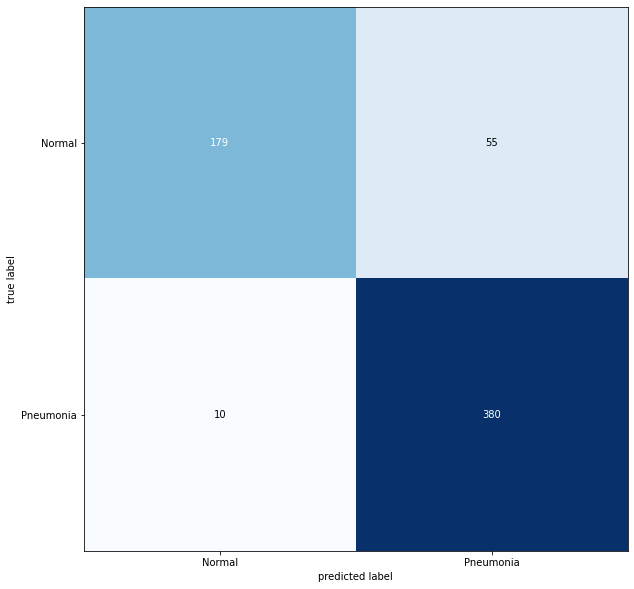

Metrics: 
Accuracy: 0.8958333333333334
Precision: 0.8735632183908046
Recall: 0.9743589743589743
F1-Score: 0.9212121212121213


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

predictions = model.predict(test_data)

# Get Accuracy and Confusion Matrix using threshold 0.5
model_accuracy = accuracy_score(test_labels, np.round(predictions))
confusion_matrix = confusion_matrix(test_labels, np.round(predictions))

true_negatives, false_positives, false_negatives, true_positives = confusion_matrix.ravel()

print("Confusion Matrix: ")
plt.figure()
plot_confusion_matrix(confusion_matrix, figsize=(10, 10), cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.show()

print("Metrics: ")
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)

print("Accuracy: {}".format(model_accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format(f1_score))

In [ ]:
# Save Model in drive to use it in API
model.save(os.path.join(MODEL_SAVE_FOLDER, 'final_model.h5'))